#***Support Vector Machines on real world data***

* **name**: Asimakis Kydros
* **srn**: 3881
* **email**: asimakis@csd.auth.gr

Support Vector Machines (SVMs) are a flavor of neural network that, instead of trying to approximate a viable non-linear decision boundary on the given input space, they elevate the space itself on a higher dimension so the problem becomes linearly seperable.

They are, by definition, binary classifiers (regressors), but they can be used for multiclass classification as well.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import seaborn as sns
import cvxopt as cpt
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestCentroid, KNeighborsClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from keras.datasets import cifar10
from scipy.sparse import csc_matrix
from itertools import combinations

DIM = 32 * 32 * 3

#**Testing on available models**

##**Case #1: Binary Classification**

Binary classification is the default problem to use an SVM on. The goal is to define a single line in the bigger dimension that biparts the space into these two classes with as few mismatches as possible.

**Importing and limiting to binary classification**

We're going to use CIFAR-10 and turn it into CIFAR-2, keeping the first two classes: airplane and automobile. They are the easiest to fetch and there is room for missclassification, as it is more natural to mistake an airplane for a car than a cat.

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

i_train, i_test = [], []

# keep only the first two classes (airplane, automobile)
for i, label in enumerate(y_train):
    if label < 2:
        i_train.append(i)

for i, label in enumerate(y_test):
    if label < 2:
        i_test.append(i)

x_train, y_train = x_train[i_train].reshape(-1, DIM), y_train[i_train]
x_test, y_test = x_test[i_test].reshape(-1, DIM), y_test[i_test]

**Raw test between default SVMs**

SKLearn provides 3 versions of SVM: the simple SVClassifier, an optimized Linear-Kernel Classifier, and $\nu$-SVClassifier, which fixes the amount of support vectors allowed. Let's perform a naive comparison to catch a sense of what approach the problem mostly needs.

In [ ]:
results = {}

for model in [SVC, LinearSVC, NuSVC]:
    cls = model()
    start = time.time()
    cls.fit(x_train, y_train.ravel())
    end = time.time()

    results[cls.__class__.__name__] = {
        'train score': round(cls.score(x_train, y_train) * 100, 2),
        'test score': round(cls.score(x_test, y_test) * 100, 2),
        'fit time': round(end - start, 2),
    }

dataframe = pd.DataFrame(results)
dataframe

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,SVC,LinearSVC,NuSVC
train score,94.31,79.05,85.80
test score,90.40,72.00,86.20
fit time,58.66,61.22,113.23


    Expected output of above code cell (ETA ~7mins):

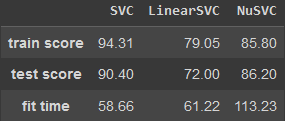

We can see that LinearSVC underperforms the most by far. It doesn't even converge in the default max iterations. That should suggest the problem is too complicated for the simple linear kernel. The other two models, that default to the RBF kernel, a much more sophisticated guide, perform much better. The classic SVM gives the best results, signifying that the increased amount of support vectors is needed to deal with the complexity of the problem.

**Applying PCA**

As with the previous classifiers, the performance can be significantly boosted by applying Principal Component Analysis on the input data. We expect that many of the given features actually hinder the model in making a decision, and are not essential in specifying the nature of the sample.

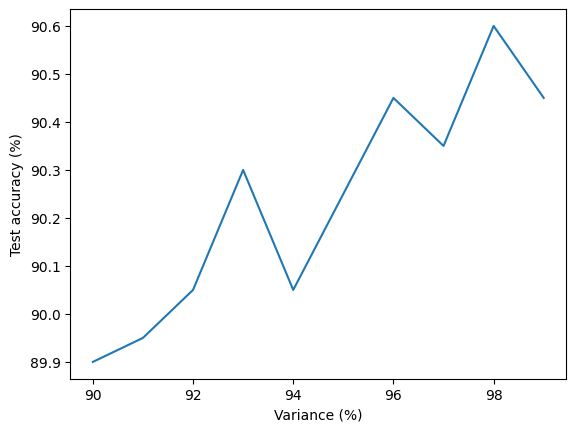

In [ ]:
svm = SVC()

results = []

for variance in range(90, 100):
    pca = PCA(variance / 100)
    x_train_reduced = pca.fit_transform(x_train)
    x_test_reduced = pca.transform(x_test)

    results.append(round(
        svm.fit(x_train_reduced, y_train.ravel())
        .score(x_test_reduced, y_test) * 100, 2
    ))

plt.plot(list(range(90, 100)), results)
plt.ylabel('Test accuracy (%)')
plt.xlabel('Variance (%)')
plt.show()

    Expected output of above code cell (ETA ~6mins):

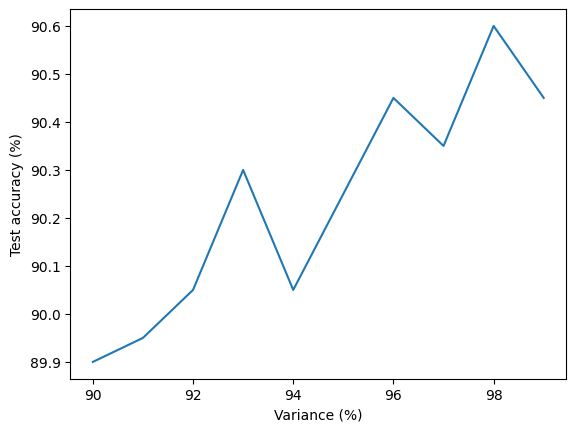

A simple comparison between variance ratios shows that the model needs 98% of the information to peak in accuracy, but the gain is apparently not great. Also, the graph grows in a very unexpected shape, almost like a a sawtooth wave. This would indicate that the model is not too able to ignore the noise provided by the extra features and instead relies on them, as extra support vectors. This results in a behavior that, if the remaining noise is just right, benefits the model, while if not it hinders it.



We saw that the accuracy gain on the peak is minimal, but the loss of complexity may lead to a benefit in speed:

In [ ]:
pca = PCA(0.98)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

svm = SVC()

start = time.time()
svm.fit(x_train, y_train.ravel())
end = time.time()
print(f'SVM after reducing: {svm.score(x_train, y_train) * 100:.2f}% train score, {svm.score(x_test, y_test) * 100:.2f}% test score, took {end - start:.2f}sec to fit.')

SVM after reducing: 94.28% train score, 90.60% test score, took 18.58sec to fit.


    Expected output of above code cell (ETA <1mins):

    SVM after reducing: 94.28% train score, 90.60% test score, took 18.58sec to fit.

Truly, it did; fit time for the model dropped from around a minute to around 20 seconds. A significant improvement, and expected considering the amount of features we discarded.

**Comparing Kernels**

There are many different kernels apart from linear and RBF. While RBF is the most sophisticated of the ones provided, it might be the case that someone else works even better for the given problem.

In [ ]:
results = {}

for kernel in ['poly', 'rbf', 'sigmoid', 'linear']:
    if kernel == 'linear':
        # the linear kernel has to be implemented like this
        # passing 'linear' in SVC actually takes 10 gazillion zillion years
        svm = LinearSVC()
    else:
        svm = SVC(kernel=kernel)

    start = time.time()
    svm.fit(x_train, y_train.ravel())
    end = time.time()

    results[kernel] = {
        'train score': round(svm.score(x_train, y_train) * 100, 2),
        'test score': round(svm.score(x_test, y_test) * 100, 2),
        'fit time': round(end - start, 2)
    }

dataframe = pd.DataFrame(results)
dataframe

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,poly,rbf,sigmoid,linear
train score,93.44,94.28,67.85,76.81
test score,85.40,90.60,69.10,77.20
fit time,17.21,10.37,9.64,9.48


    Expected output of above code cell (ETA ~1min):

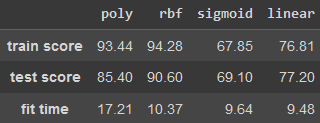


Not really. We already saw that the linear kernel is not suitable for the problem, but it's significant to point out that its traditional implementation is exponentially worse; not only does it not converge, it also takes ages to finish execution. Sigmoid fares even worse, but that kernel is too reliant on magic hyperparameters anyway. The polynomial kernel on the other hand tends to be on par with RBF, having a smaller training accuracy which might indicate that it overfits less. RBF however maximizes both testing accuracy and small fit time, so we are going to go with that one.

**Outputs of RBF Kernel**

Let us now analyze the results of the SVM with the RBF Kernel.

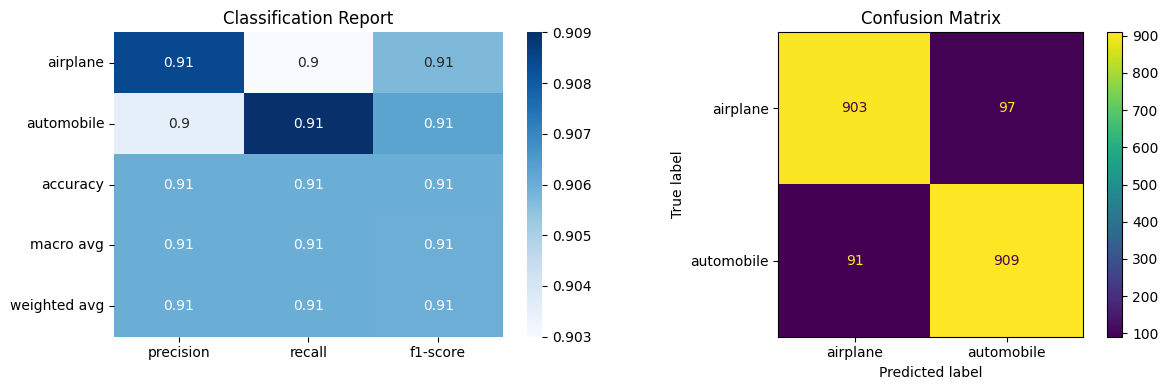

In [ ]:
svm = SVC()
svm.fit(x_train, y_train.ravel())
classes = ['airplane', 'automobile']
predictions = svm.predict(x_test)

from matplotlib import gridspec

fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

# plot classification report heatmap
axis_0 = plt.subplot(gs[0])
report = classification_report(y_test, predictions, output_dict=True, target_names=classes)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='Blues', ax=axis_0)
axis_0.set_title('Classification Report')

# plot confusion matrix heatmap
axis_1 = plt.subplot(gs[1])
ConfusionMatrixDisplay.from_predictions(y_test, predictions, display_labels=classes, ax=axis_1)
axis_1.set_title('Confusion Matrix')

plt.tight_layout()
plt.show()

    Expected output of above code cell (ETA 14sec):

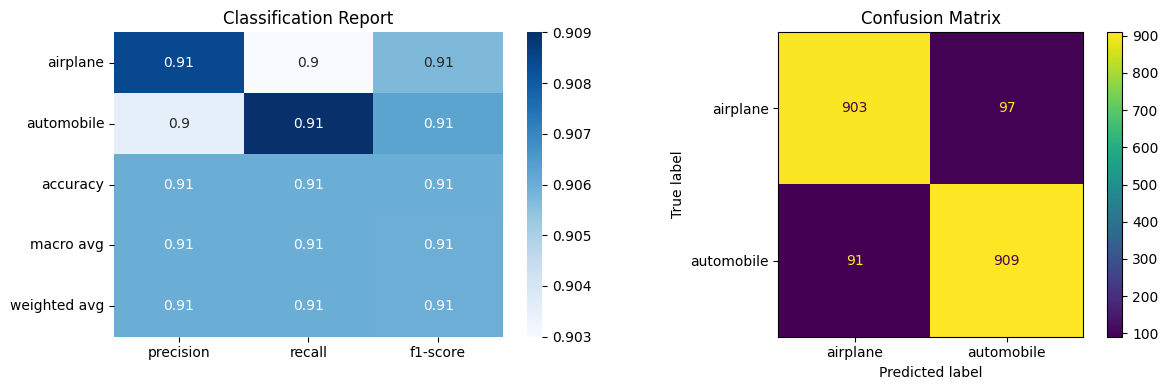

All metrics sit comfortably at 91%, showing that, at the general case, the model solves the binary problem with relatively few errors. The confusion matrix shows that the true to predicted ratio is as high as desired.

We should also check some examples of correct and incorrect classification to gain insight on what the model does right.

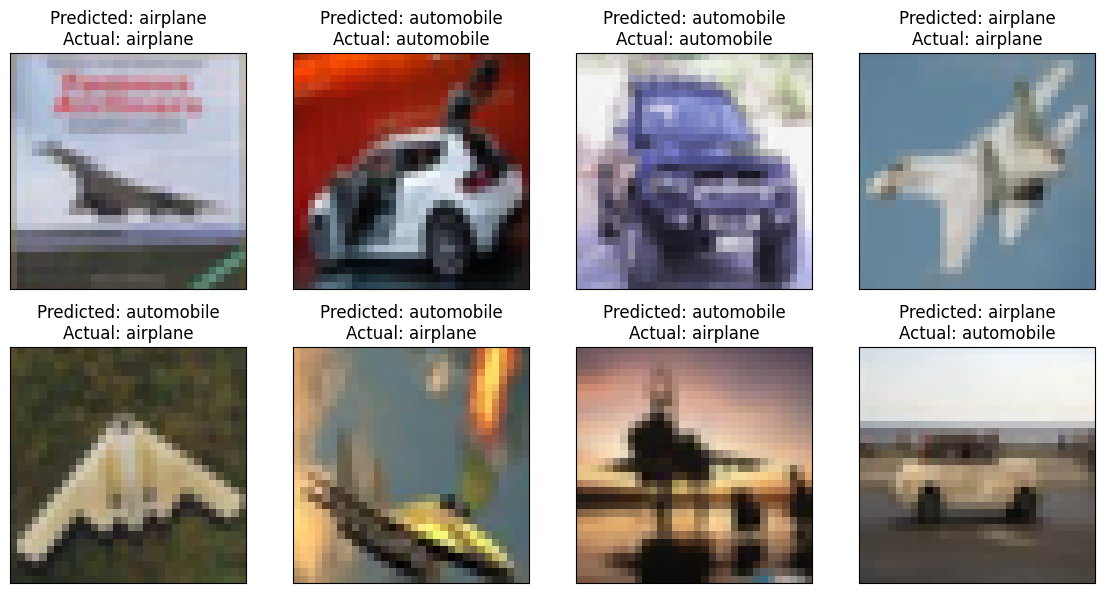

In [ ]:
fig, axarr = plt.subplots(2, 4, figsize=(14, 7))
(_, _), (test_images, _) = cifar10.load_data()

for row in range(2):
    i = 0
    for image, prediction, truth in zip(test_images[i_test], predictions, y_test.ravel()):
        if i > 3:
            break
        if (row == 0 and prediction == truth) or (row == 1 and prediction != truth):
            axarr[row, i].imshow(image)
            axarr[row, i].set_xticks([])
            axarr[row, i].set_yticks([])
            axarr[row, i].set_title(f'Predicted: {classes[prediction]}\nActual: {classes[truth]}')
            i += 1
plt.show()

    Expected output of above code cell (ETA <1sec):

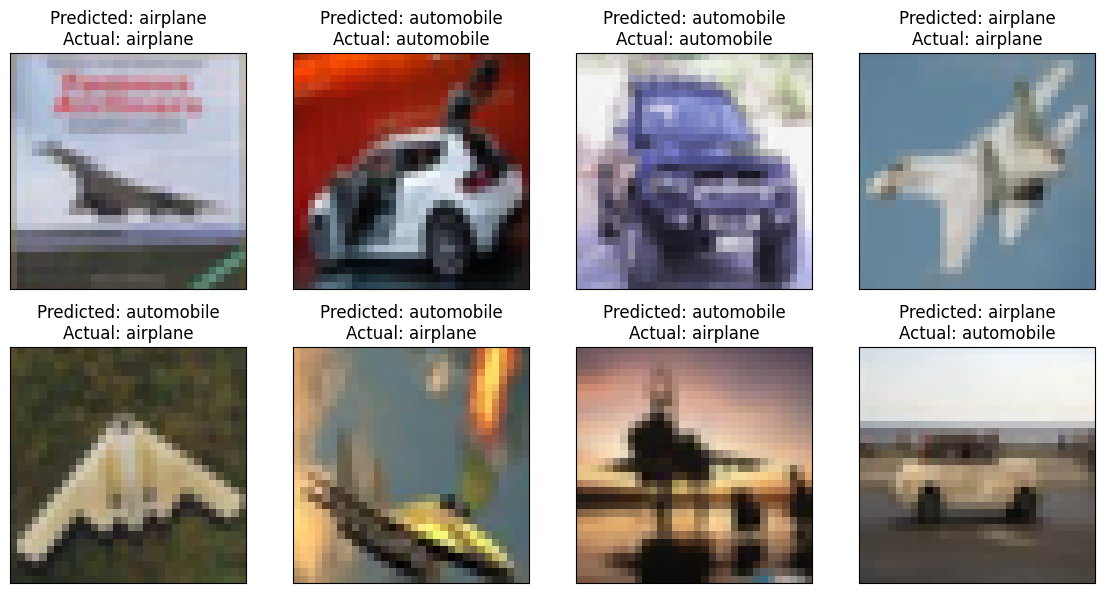

The mistakes it makes are honestly weird and varied. It very clearly hasn't learned the shape of the average car, as the triangular plane on the bottom first image most certaintly isn't a car. It would seem that it learned the color of the background, as a clear white/blue sky almost always correlates with an airplane, while other cases appear under automobile. Not desired but not too surprising either, considering that most of the features have to do with the background, most of the time.

**Hyperparameter tuning**

Up until this point we have dealt with the default parameters of SKLearn. We should dig into which values suit our problem best.

In [ ]:
grid_search = GridSearchCV (
    SVC(),
    {'gamma': ['scale', 'auto'],
     'shrinking': [True, False],
     'class_weight': [None, 'balanced'],
     'C': [1, 100, 1000],
    },
    cv=5,
    n_jobs=-1
)
grid_search.fit(x_train, y_train.ravel())

print(f'Best combination in grid: {grid_search.best_params_}\n')

Best combination in grid: {'C': 100, 'class_weight': None, 'gamma': 'scale', 'shrinking': True}



    Expected output of above code cell (ETA ~24mins):

    Best combination in grid: {'C': 100, 'class_weight': None, 'gamma': 'scale', 'shrinking': True}

We are lucky that the RBF kernel nullifies many extra parameters, and that also each classifier takes less than a minute to run. The results we get aren't surprising; class_weight is determined to None, which makes sense as the dataset is perfectly balanced already. Gamma scaling is more sophisticated than the auto version and is thus generally expected to be prefered. The shrinking heuristic has mostly to do with the sped-up of the optimization, not the improvement of convergence, but that can indirectly help accuracy as well.

However, the C we receive as 'best' might be misleading; we haven't tested an adequate amount of values for the sake of runtime. We learned though that the presumed best lies between $(1.0, 100.0)$. We should do a more thorough search on that hyperparameter alone:

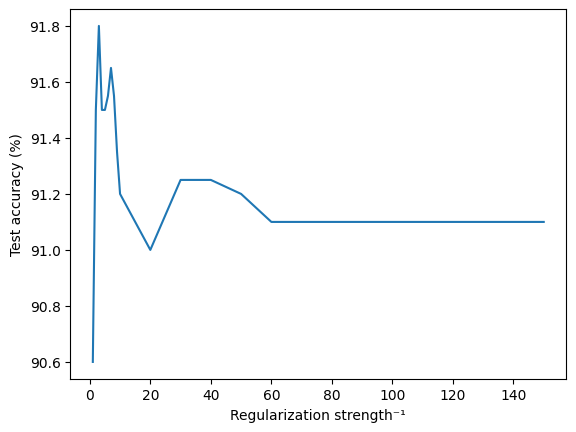

In [ ]:
scores = []

for c in range(1, 10):
    svm = SVC(C=c)
    svm.fit(x_train, y_train.ravel())
    scores.append(round(svm.score(x_test, y_test) * 100, 2))

for c in range(10, 160, 10):
    svm = SVC(C=c)
    svm.fit(x_train, y_train.ravel())
    scores.append(round(svm.score(x_test, y_test) * 100, 2))

xaxis = list(range(1, 10)) + list(range(10, 160, 10))

plt.plot(xaxis, scores)
plt.ylabel('Test accuracy (%)')
plt.xlabel('Regularization strength⁻¹')
plt.show()

    Expected output of above code cell (ETA <1sec):

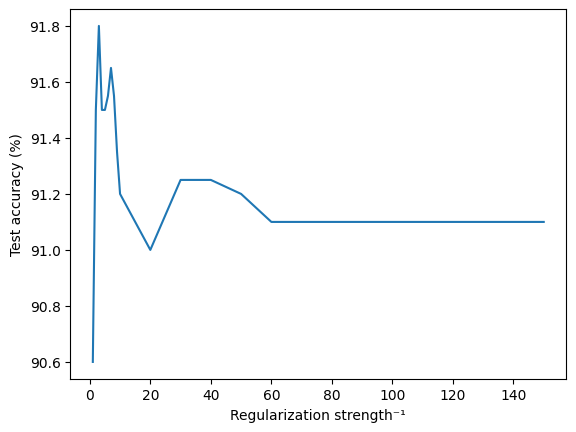

In [ ]:
i = np.argmax(scores)
print(f'C={xaxis[i]} gives max accuracy of {scores[i]}%')

C=3 gives max accuracy of 91.8%


    Expected output of above code cell (ETA <1sec):

    C=3 gives max accuracy of 91.8%

A regularization strength of $\frac{1}{3}$ is adequate for boosting accuracy to ~92%. Further pressuring the machine to make less errors has little impact on accuracy, and a mostly asymptotically diminishing one. It would seem that, even though the machine prefers to use many support vectors to deal with the given problem, it doesn't go overboard and instead judges the smoothness of the boundary more prefereable.

**Comparison with previous classifiers**

Let us compare the presumably optimal version of the SVM with the previous MLP model and also the simpler classification models.

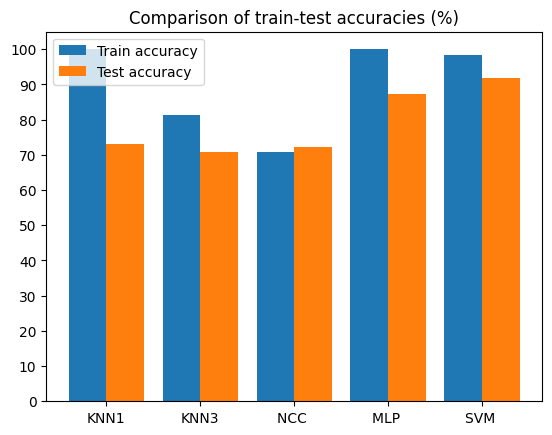

In [ ]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn3 = KNeighborsClassifier(n_neighbors=3)
ncc = NearestCentroid()
mlp = MLPClassifier((1024, 1024), batch_size=300, alpha=0.001)
svm = SVC(C=3)

results = {}

for label, cls in zip(['KNN1', 'KNN3', 'NCC ', 'MLP ', 'SVM '], [knn1, knn3, ncc, mlp, svm]):
    start = time.time()
    cls.fit(x_train, y_train.ravel())
    end = time.time()

    results[label] = {
        'train accuracy': round(cls.score(x_train, y_train) * 100, 2),
        'test accuracy': round(cls.score(x_test, y_test) * 100, 2),
        'fit time': round(end - start, 2)
    }

# plot in bar graph
indeces = np.arange(len(results))

plt.bar(indeces, [results[listing]['train accuracy'] for listing in results], width=0.4, label='Train accuracy')
plt.bar(indeces + 0.4, [results[listing]['test accuracy'] for listing in results], width=0.4, label='Test accuracy')
plt.title('Comparison of train-test accuracies (%)')
plt.xticks(indeces + 0.2, results.keys())
plt.yticks(range(0, 110, 10))
plt.legend()
plt.show()


    Expected output of above code cell (ETA ~5mins):

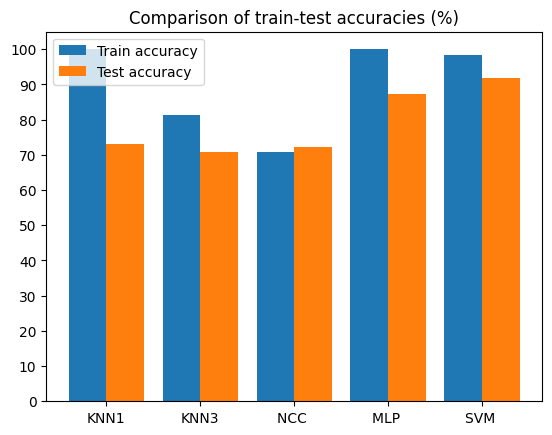

The SVM towers in performance in contrast with the rest; not only it has the better accuracy, it also overfits much less. It's also much faster than the MLP (shown below), as it escapes from iterative training schemas.

In [ ]:
dataframe = pd.DataFrame(results)
dataframe

,KNN1,KNN3,NCC,MLP,SVM
train accuracy,100.00,81.47,70.76,100.00,98.25
test accuracy,73.20,70.85,72.30,87.30,91.80
fit time,0.03,0.02,0.04,214.74,19.45


    Expected output of above code cell (ETA <1sec):

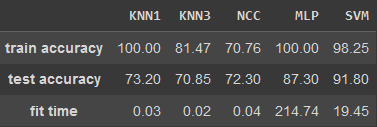

We should also check the support vectors it settles on:

In [ ]:
print(f'Support Vector matrix shape: {svm.support_vectors_.shape}\n')

dataframe = pd.DataFrame(svm.support_vectors_)
dataframe.head()

Support Vector matrix shape: (4150, 418)



,0,1,2,3,4,5,6,7,8,9,...,408,409,410,411,412,413,414,415,416,417
0,-2053.507158,-1499.135335,-1483.755752,-261.407519,-122.540407,-285.502075,962.907258,-2075.859752,874.477508,190.925771,...,33.704547,19.958899,19.283431,4.721497,19.063482,-9.893331,1.311873,39.590001,-42.777560,-53.035356
1,526.615039,405.754904,438.195437,601.549010,-183.736656,3.940367,28.652769,454.578252,191.094957,194.506166,...,61.241900,-34.385304,57.274706,-38.544401,37.036246,-15.720190,-23.768589,-10.814194,-9.496326,9.059563
2,1006.972306,-807.095637,-926.739196,1475.241602,864.516977,68.880974,-241.203099,-369.340539,39.405242,-29.972057,...,32.661055,-28.890758,13.185959,0.830647,4.394029,8.587425,-61.192308,-51.202326,-39.160482,-39.644949
3,-3979.027687,1244.538638,-1124.401185,395.886131,973.003091,92.392634,-443.811260,331.685985,-570.694985,-70.625050,...,-8.372701,-16.292860,-87.995706,120.277246,13.057966,-63.243301,-9.189987,73.770842,56.233623,-6.814371
4,2519.597469,193.742893,1303.333399,322.386043,96.939026,-490.970745,-429.579231,22.935513,-406.734202,836.078481,...,-23.594448,-42.333194,6.589795,25.597773,9.037112,-59.351712,36.730343,1.762932,-1.863439,-3.149202


    Expected output of above code cell (ETA <1sec):

    Support Vector matrix shape: (4150, 418)

    + the actual matrix which is so huge I can't even screenshot it (sorry).

Nearly half of the input dataset is used as support vectors (each class in CIFAR-10 has 5000 samples). Presumably, it uses half the samples of each class to shape the margin. Based on what we saw earlier, that was something to be expected.

##**Case #2: Multiclass Classification**

Of course, most real-life problems have significantly more classes than 2. While a single SVM performs binary classification, OneVsOne or OneVsRest schemes can be used to achieve a multiclass approach.

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

labels = np.array([
    'airplane', 'automobile', 'bird',
    'cat', 'deer', 'dog', 'frog',
    'horse', 'ship', 'truck'
])

pca = PCA(0.92)

x_train = pca.fit_transform(x_train.reshape(-1, DIM))
x_test = pca.transform(x_test.reshape(-1, DIM))

SKLearn, by default, uses an OVO scheme for multiclass support. We should follow suit for a fairer comparison. Let's test that one first, with input data reduced to 92% variance, which was found to be the best when testing MLPs.

In [ ]:
svm = SVC()
svm.fit(x_train, y_train.ravel())
print(f'score = {svm.score(x_test, y_test) * 100:.2f}%')

score = 54.37%


    Expected output of above code cell (ETA ~2h):

    score = 54.37%

The machine scores 54% accuracy, which is around what the best MLP gave previously.

**OneVsOne SVM**

This model performs One vs One classification by splitting the input data into $\frac{n(n-1)}{2}$ subsets of class pairs, and then training that many binary SVM classifiers on these subsets, using the hyperparameter values that were found to be best previously. For prediction, it performs hard voting.

In [ ]:
class MulticlassSVM:
    def __init__(self, n_classes):
        self.__classes = n_classes
        self.estimators = None

    def fit(self, x, y):
        y_ovo_i = list(combinations(range(self.__classes), 2))
        self.estimators = {}

        for (class_1, class_2) in y_ovo_i:
            indeces = np.argwhere((y == class_1) | (y == class_2)).ravel()
            x_ij, y_ij = x[indeces], y[indeces]
            self.estimators[f'{class_1}v{class_2}'] = SVC(C=3).fit(x_ij, y_ij)

        return self

    def predict(self, x):
        votes = np.zeros((len(x), self.__classes))

        for key, estimator in self.estimators.items():
            class_1, class_2 = map(int, key.split('v'))
            partial_pred = estimator.predict(x)
            votes[partial_pred == class_1, class_1] += 1
            votes[partial_pred == class_2, class_2] += 1

        return np.argmax(votes, axis=1)

    def score(self, x, y):
        preds = self.predict(x)
        return accuracy_score(y, preds)

In [ ]:
svm = MulticlassSVM(len(labels))
start = time.time()
svm.fit(x_train, y_train.ravel())
end = time.time()
print(f'OvO SVM: {svm.score(x_train, y_train) * 100:.2f}% train score, {svm.score(x_test, y_test) * 100:.2f}% test score, {end - start:.2f}sec fit time')

OvO SVM: 81.11% train score, 56.51% test score, 355.91sec fit time


    Expected output of above code cell (ETA ~51mins):

    OvO SVM: 81.11% train score, 56.51% test score, 355.91sec fit time

This model fares significantly better than the arleady available one, scoring slightly better in testing and halving the execution time. This is of course due to the internal classifiers being cherrypicked, i.e. pre-tuned with optimal hyperparameter values.

**Output visualization**

The model scores better, but we should once again analyze why and where by visualizing the output.

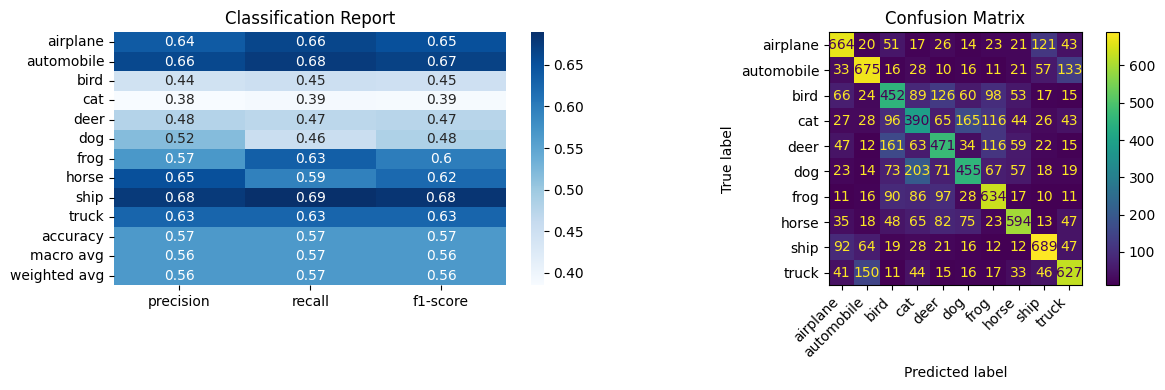

In [ ]:
from matplotlib import gridspec

predictions = svm.predict(x_test)

fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

# plot classification report heatmap
axis_0 = plt.subplot(gs[0])
report = classification_report(y_test, predictions, output_dict=True, target_names=labels)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='Blues', ax=axis_0)
axis_0.set_title('Classification Report')

# plot confusion matrix heatmap
axis_1 = plt.subplot(gs[1])
ConfusionMatrixDisplay.from_predictions(y_test, predictions, display_labels=labels, ax=axis_1)
axis_1.set_title('Confusion Matrix')
axis_1.set_xticklabels(labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()

    Expected output of above code cell (ETA ~8mins):

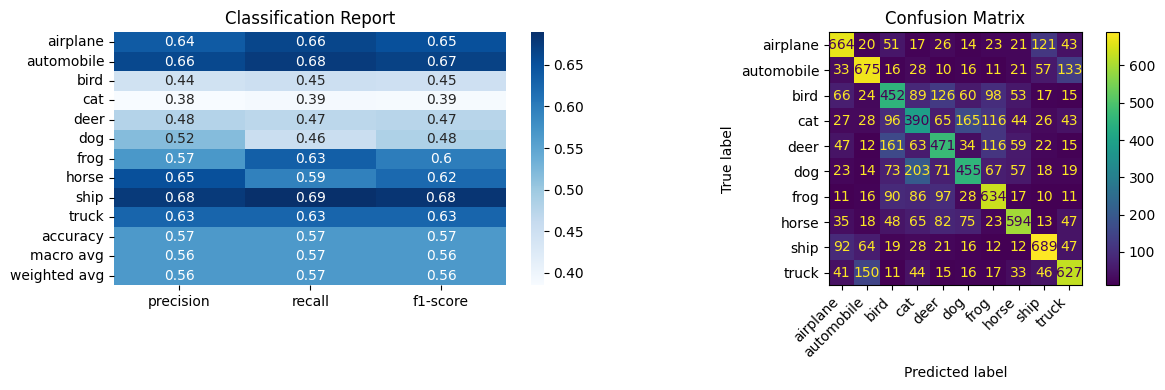

It's obvious from the above heatmaps that the model is far better at recognizing airplanes and automobiles (and also ships apparently, but this might be luck) than anything else. This must be because each classifier uses the hyperparameters found optimal for the binary classification of said classes. While it still performs adequately, this phenomenon clearly signifies that a personal tuning for each estimator will further boost the total model's performance.

Again, let's see match-mismatch examples to see what the model truly learned:

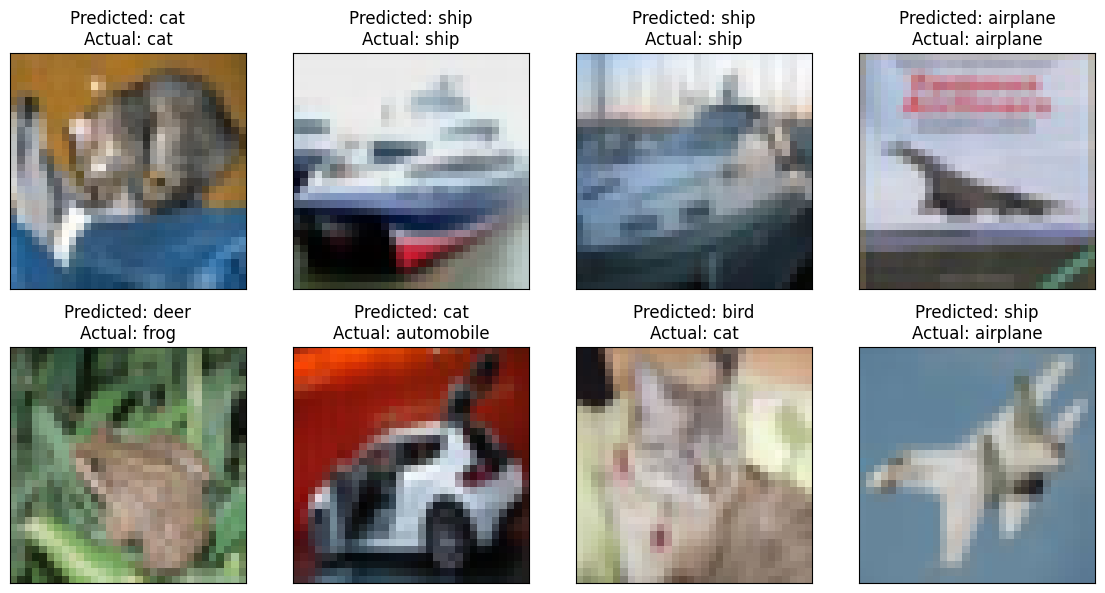

In [ ]:
fig, axarr = plt.subplots(2, 4, figsize=(14, 7))
(_, _), (test_images, _) = cifar10.load_data()

for row in range(2):
    i = 0
    for image, prediction, truth in zip(test_images, predictions, y_test.ravel()):
        if i > 3:
            break
        if (row == 0 and prediction == truth) or (row == 1 and prediction != truth):
            axarr[row, i].imshow(image)
            axarr[row, i].set_xticks([])
            axarr[row, i].set_yticks([])
            axarr[row, i].set_title(f'Predicted: {labels[prediction]}\nActual: {labels[truth]}')
            i += 1
plt.show()

    Expected output of above code cell (ETA ~5sec):

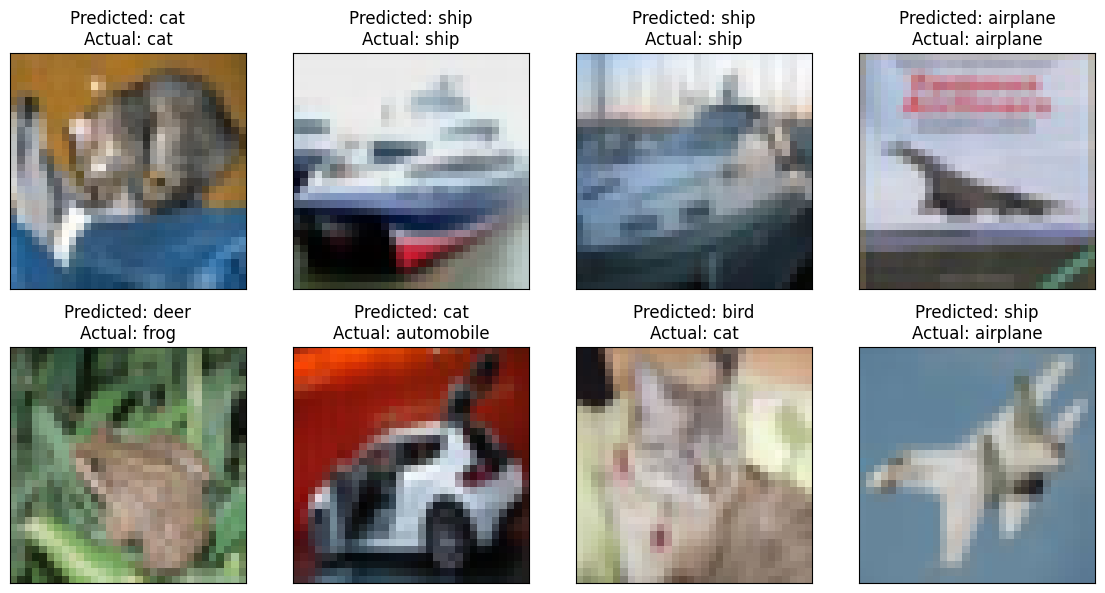

As expected, the errors are much more profound; it would seem that a lot of blue now guides the estimator into thinking it looks at sea, and thus at a ship. The smartcar being predicted as a cat might mean that the classifier correlates the round shape into a furball, much like top image 1, and the open door could also be mistaken for a tail. The bottom first classification looks bizzare, but again the colors might guide thinking into forests and brown animals, which in the given context the model has learned generally describes a deer.

**Appending an SVM to an MLP**

An interesting way to combine models is to use an MLP as a data preprocessor, training it with the original data in the hope that, the representation it converges to in the final hidden layer will be a compressed, generic and essence-achieving version of the input. We can then pass this representation as input in an SVM.

SKLearn doesn't offer a pre-implemented, explicit way to access the hidden layer output. The below function manages it by 'hacking' MLPClassifier._predict.

In [ ]:
def get_final_hidden_layer(clf, X):
    # thanks to https://stackoverflow.com/a/46730656
    hidden_layer_sizes = clf.hidden_layer_sizes
    if not hasattr(hidden_layer_sizes, "__iter__"):
        hidden_layer_sizes = [hidden_layer_sizes]
    hidden_layer_sizes = list(hidden_layer_sizes)
    layer_units = [X.shape[1]] + hidden_layer_sizes + [clf.n_outputs_]
    activations = [X]
    for i in range(clf.n_layers_ - 1):
        activations.append(np.empty((X.shape[0], layer_units[i + 1])))
    clf._forward_pass(activations)
    return activations[-2]

Let's test it; the reduced representation might be just tame enough for the linear kernel to handle, so we should test that one as well.

In [ ]:
mlp = MLPClassifier((1024, 1024), alpha=0.001, batch_size=300)
start = time.time()
mlp.fit(x_train, y_train.ravel())
end = time.time()

x_train_processed = get_final_hidden_layer(mlp, x_train)
x_test_processed = get_final_hidden_layer(mlp, x_test)

results = {}

for cls in [SVC(C=3), LinearSVC(C=3)]:
    start_1 = time.time()
    cls.fit(x_train_processed, y_train.ravel())
    end_1 = time.time()

    results[cls.__class__.__name__] = {
        'train score': round(cls.score(x_train_processed, y_train) * 100, 2),
        'test score': round(cls.score(x_test_processed, y_test) * 100, 2),
        'fit time': round(end - start + end_1 - start_1, 2)
    }

dataframe = pd.DataFrame(results)
dataframe

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,SVC,LinearSVC
train score,93.96,78.53
test score,48.25,41.80
fit time,3552.86,3212.62


    Expected output of above code cell (ETA ~1h20m):

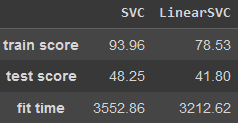

The accuracy level has dropped significantly, and fit time has risen tremendously. What is more, the standard SVM overfits maximally; it might be the case that the MLP has compressed most of the useful features, such that the models struggle to find a smooth margin and use more and more samples as support vectors, leading to increased overfitting and minimal generality.

**Comparison with other classifiers**

Let us now compare the performance of all the classifiers we have seen to the multiclass case.

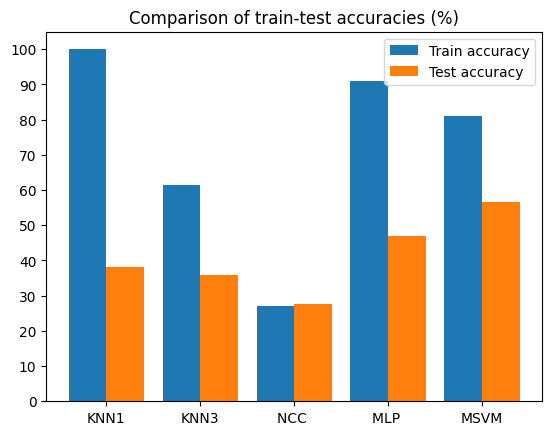

In [ ]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn3 = KNeighborsClassifier(n_neighbors=3)
ncc = NearestCentroid()
mlp = MLPClassifier((1024, 1024), batch_size=300, alpha=0.001)

results = {}

for label, cls in zip(['KNN1', 'KNN3', 'NCC ', 'MLP '], [knn1, knn3, ncc, mlp]):
    start = time.time()
    cls.fit(x_train, y_train.ravel())
    end = time.time()

    results[label] = {
        'train accuracy': round(cls.score(x_train, y_train) * 100, 2),
        'test accuracy': round(cls.score(x_test, y_test) * 100, 2),
        'fit time': round(end - start, 2)
    }

# manually include the stats for MulticlassSVM, as they were precalculated above
results['MSVM'] = {
    'train accuracy': 81.11,
    'test accuracy': 56.51,
    'fit time': 355.91
}

# plot in bar graph
indeces = np.arange(len(results))

plt.bar(indeces, [results[listing]['train accuracy'] for listing in results], width=0.4, label='Train accuracy')
plt.bar(indeces + 0.4, [results[listing]['test accuracy'] for listing in results], width=0.4, label='Test accuracy')
plt.title('Comparison of train-test accuracies (%)')
plt.xticks(indeces + 0.2, results.keys())
plt.yticks(range(0, 110, 10))
plt.legend()
plt.show()

    Expected output of above code cell (ETA ~46mins):

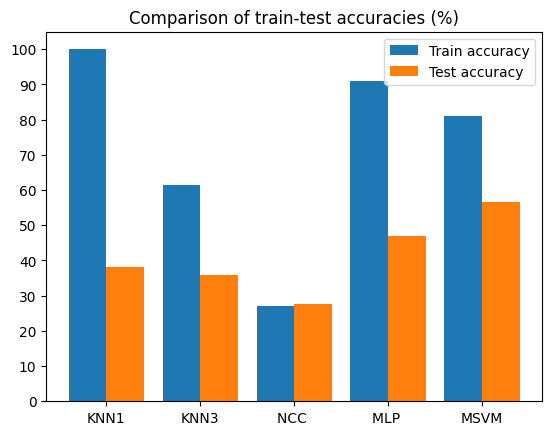

We've already seen how the Neighbor-based models overfit like crazy and the Centroid classifier struggles to cope with the increased complexity. The OVO Multiclass SVM handles overfitting much better in general, even managing to surpass the MLP in testing accuracy. While still not ideal, it is evident that dividing the problem into 1v1 seperable problems and then ensembling them is a smarter approach than interconnecting all the feature channels in the hopes of brute forcing a decision function.

#**SVM from scratch**

The architecture of a simple Support Vector Machine is a very interesting one. Two slightly different approaches are provided below. Both of them essentially boil down to finding the optimal Lagrangian variables of the dual Optimization problem

$$
    \begin{align}
        \text{argmax}_\vec{A}& \text{ }\vec{A} - \frac{1}{2}\vec{A}^T\textbf{Q}\vec{A}, \text{ } \textbf{Q} = (\vec{Y} \otimes \vec{Y}) * \mathbb{K}_{x\times x}\\
        \text{subject to }&\\
                        &0 \leq a_k \leq C \text{    } \forall a_k\in\vec{A}, \\
                        & \vec{A}\cdot\vec{Y} = 0
    \end{align}
$$

and using them to define the margin line.

Note that both models use the RBF kernel $ e^{-\gamma||x - x'||^2}$ for $\mathbb{K}$.


##**Batch Gradient Ascent**

This first one calculates $\vec{A}$ iteratively with Gradient Ascent, using the derivative of the Objective Function as update:

$$
    \vec{A} \leftarrow \vec{A} + \beta(\vec{1} - \textbf{Q}\vec{A})
$$

where $\beta$ the given learning rate.

As the dataset is fairly big, and the Kernel Matrix becomes approprietly massive for the available RAM, a batch training scheme is implemented.


In [ ]:
class SVM:
    def __init__(self, reg_param: float=1.0, gamma: str='auto', learning_rate: float=0.001, max_iter: int=200, batch_size: int=500):
        self.c = reg_param
        self.gamma_s = gamma
        self.lr = learning_rate
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.gamma = None
        self.decision_function = None
        self.support_vectors = None

    def kernel(self, x1: np.ndarray, x2: np.ndarray):
        # RBF kernel: exp(-gamma||x - x'||^2)
        k = np.zeros((len(x1), len(x2)))
        for i, xi in enumerate(x1):
            for j, xj in enumerate(x2):
                k[i, j] = np.exp(-self.gamma * np.linalg.norm(xi - xj) ** 2)
        return k

    def fit(self, x: np.ndarray, y: np.ndarray):
        self.gamma = 1 / (len(x[0]) * x.var()) if self.gamma_s == 'scale' else 1 / len(x[0])
        alphas = np.zeros(len(x)).reshape(-1, 1)

        # batch training
        for start in range(0, len(x), self.batch_size):
            end = min(start + self.batch_size, len(x))
            Q_batch = np.outer(y[start:end], y) * self.kernel(x[start:end], x)
            # gradient ascent to find lagrangians
            for epoch in range(self.max_iter):
                alphas[start:end] += self.lr * (1 - Q_batch @ alphas)
                np.clip(alphas, 0, self.c, out=alphas)

        # b calculation
        i_supp_vec = np.argwhere(alphas > 0).ravel()
        alphas_sv = alphas[i_supp_vec].reshape(-1, 1)
        self.support_vectors = x[i_supp_vec]
        y_sv = y[i_supp_vec].reshape(-1, 1)
        ay_sv = alphas_sv * y_sv
        K = np.argmax(alphas_sv.ravel())

        # b = yK - (\sum akykΦ(xk))K.xK s.t.  ak > 0, K = argmax(ak)
        b = y_sv[K] - self.kernel(self.support_vectors, self.support_vectors)[K] @ ay_sv

        # w.Φ(x) - b
        self.decision_function = lambda other: self.kernel(other, self.support_vectors) @ ay_sv + b
        return self

    def predict(self, x: np.ndarray):
        preds = np.zeros(len(x)).reshape(-1, 1)

        for start in range(0, len(x), self.batch_size):
            end = min(start + self.batch_size, len(x))
            # f(x, w, b) = sign(w.Φ(x) - b)
            preds[start:end] = np.sign(self.decision_function(x[start:end]))

        return preds

    def score(self, x: np.ndarray, y: np.ndarray):
        return accuracy_score(y, self.predict(x))

**Issues met**:
* The kernel would frequently hog all the RAM and cause a crash;
    - This was due to many factors; chief among them was the fact that I was adamant to declare it using lambda instead of creating a seperate function, resulting to a hacked implementation that made redundant calculations and stored same-pair distances multiple times.
* Still, Gradient Ascent could not handle the entire dataset at once;
    - Batch training to the rescue. I was surprised at how intuitive it was to implement (without claiming the final product is 100% correct, it just seems so).
* The machine would consistently return a perfect 50% train-test accuracy;
    - That was awfully suspicious; more so the fact that after some changes, the execution time dropped to 3 seconds. I found that changing the **alphas** initialization from zeros to randomized in the (-1, 1) range helped somewhat, in the sense that it changed from dead 50 to ~10%. I later traced the error to the definition of **b**, which was a mess of its own, explained as follows.
* Re-made it with context from the QP implementation;
    - Slow but works much better.
    - An ignorant mistake, but, after batch-training, I would not explicitly use the support vectors and their corresponding **a**, **y** and **kernel** to define the decision function. This would lead again to memory explosions and poorly implemented code, **b** for example, which at one point was the mean of the entire dataset.

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

i_train = [i for i, label in enumerate(y_train) if label < 2]
i_test = [i for i, label in enumerate(y_test) if label < 2]
scaler = StandardScaler()
pca = PCA(0.98)

x_train = pca.fit_transform(scaler.fit_transform(x_train[i_train].reshape(-1, DIM)))
x_test = pca.transform(scaler.transform(x_test[i_test].reshape(-1, DIM)))
y_train = y_train[i_train]
y_test = y_test[i_test]

In [ ]:
svm = SVM()
svm.fit(x_train, y_train)
print(f'train score: {svm.score(x_train, y_train) * 100:.2f}%, test score: {svm.score(x_test, y_test) * 100:.2f}%')

train score: 50.00%, test score: 49.65%


    Expected output of above code cell (ETA ~1h38min):

    train score: 50.00%, test score: 49.65%

The model scores around 50%. Not perfect but good enough for a naive implementation. Fit time is increased but that could be to many factors, including but not limited to the fact that it is implemented in python with 0 optimization efforts. 50% training score is a bit surprising, but at least the model doesn't overfit.

##**Quadratic Programming**

This one solves the dual problem again, but instead of Gradient Ascent, it solves the KKT conditions using the **cvxopt** library.

The thinking is the same, but note that the inequality constraint had to be represented with the following trick, as it is a double one and the library accepts only a singular one:

$$
    \forall a_k\in\vec{A}:\text{ }0 \leq a_k \leq C \Rightarrow -a_k \leq 0 \land a_k \leq C \Rightarrow\\
    \begin{align}
        -1\textbf{I} \vec{A} &\leq \vec{0}\\
         \textbf{I}  \vec{A} &\leq C\vec{1}
    \end{align}
$$

therefore

$$
    \textbf{G} = \begin{bmatrix}
                    -1 & 0 & \cdots & 0\\
                    0 & -1 & \cdots & 0\\
                    \vdots & \vdots & \ddots & \vdots\\
                    0 & 0 & \cdots & -1\\
                    1 & 0 & \cdots & 0\\
                    0 & 1 & \cdots & 0\\
                    \vdots & \vdots & \ddots & \vdots\\
                    0 & 0 & \cdots & 1
                 \end{bmatrix},
    \vec{h} = \begin{bmatrix}
                    0\\
                    0\\
                    \vdots\\
                    0\\
                    C\\
                    C\\
                    \vdots\\
                    C
                \end{bmatrix}
$$

In [ ]:
class SVM:
    def __init__(self, reg_param: float=1.0, gamma: str='auto'):
        self.c = reg_param
        self.gamma_s = gamma
        self.gamma = None
        self.decision_function = None
        self.support_vectors = None

    def kernel(self, x1: np.ndarray, x2: np.ndarray):
        # RBF kernel: exp(-gamma||x - x'||^2)
        k = np.zeros((len(x1), len(x2)))
        for i, xi in enumerate(x1):
            for j, xj in enumerate(x2):
                k[i, j] = np.exp(-self.gamma * np.linalg.norm(xi - xj) ** 2)
        return k

    def fit(self, x: np.ndarray, y: np.ndarray):
        cpt.solvers.options['show_progress'] = False  # silence solver
        self.gamma = 1 / (len(x[0]) * x.var()) if self.gamma_s == 'scale' else 1 / len(x[0])
        # QP terms
        K = self.kernel(x, x)
        Q = cpt.matrix(np.outer(y, y) * K)
        i = cpt.matrix(np.ones(len(x)) * -1)
        Y = cpt.matrix(y.T.tolist(), (1, len(y)), 'd')
        O = cpt.matrix(0.0)
        G = cpt.matrix(np.vstack((      # 2nxn matrix, n: #rows of X
            np.eye(len(x)) * -1 + 0.0,  # -1 diagonal the top half-square
            np.eye(len(x))              # 1 diagonal the bottom half.
        )))                             # Ga <= h strictly so top means a >= h1, a <= h2.
        h = cpt.matrix(np.hstack((      # 1x2n matrix, zeros the first half
            np.zeros(len(x)),           # C the rest. 0 <= ak <= C
            np.ones(len(x)) * self.c    # therefore all ak gain ak >= 0, ak <= C
        )))                             # with their combination.
        # argmax_A i.A - 1/2A^TQA
        # s.t. 0 <= A <= C (first halves of G,h models the first inequality, etc)
        #      A.Y = 0 (O)
        solution = cpt.solvers.qp(Q, i, G, h, Y, O)
        alphas = np.ravel(solution['x'])

        # b calculation
        i_supp_vec = np.argwhere(alphas > 0).ravel()
        alphas_sv = alphas[i_supp_vec].reshape(-1, 1)
        self.support_vectors = x[i_supp_vec]
        y_sv = y[i_supp_vec].reshape(-1, 1)
        ay_sv = alphas_sv * y_sv
        # b = yK - (\sum akykΦ(xk))K.xK s.t.  ak > 0, K = argmax(ak)
        b = (y_sv - K[i_supp_vec][:, i_supp_vec] @ ay_sv)[np.argmax(alphas_sv.ravel())]

        # w.Φ(x) - b
        self.decision_function = lambda other: self.kernel(other, self.support_vectors) @ ay_sv + b
        return self

    def predict(self, x: np.ndarray):
        return np.sign(self.decision_function(x))

    def score(self, x: np.ndarray, y: np.ndarray):
        return accuracy_score(y, self.predict(x))

**Issues met**:
* First used library **cvxpy**, failed cause the problem is non-convex;
    - Fair enough, but why does this library work? Supposedly this also only works for convex problems and the one at hand is definitely not convex.
* Declaration of **Y** throwed **TypeError: Buffer format not supported**;
    - Apparently this is a bug in the library (lol), could not for the life of me find a valid solution, only the workaround provided.
* Train and test sets are ginormous when the kernel is concerned;
    - Had to use a much smaller training set and test in batches (sorry).
* **b** would be computed into a column vector;
    - **alphas** and **y** are column vectors, their broadcast gives a column vector, but then argmax interprets the request as return the argmax of every *row*, when I want the argmax of the column.
    - Also I would invoke the Kernel matrix the wrong way, getting a column vector instead of a square matrix.

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

i_train = np.array([i for i, class_i in enumerate(y_train) if class_i < 2])
i_test = np.array([i for i, class_i in enumerate(y_test) if class_i < 2])
scaler = StandardScaler()
pca = PCA(0.98)

x_train = pca.fit_transform(scaler.fit_transform(x_train[i_train].reshape(-1, DIM)))
x_test = pca.transform(scaler.transform(x_test[i_test].reshape(-1, DIM)))
y_train = y_train[i_train]
y_test = y_test[i_test]

In [ ]:
svm = SVM()
svm.fit(x_train, y_train)
print(f'train score = {svm.score(x_train, y_train) * 100:.2f}%, test score = {svm.score(x_test, y_test) * 100:.2f}%')

train score = 49.73%, test score = 49.45%


    Expected output of above code cell (ETA ~39mins):

    train score = 49.73%, test score = 49.45%

Similar results with the above version, as expected. Sophisticated definitions of **b** could really improve the performance. This attempt is only slightly worse at accuracy, but achieves a much better execution time, which was to be expected as an external library was used.